# Intro
This is based on the [code](http://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/) from Daniel Weitzenfeld.

I adapted the approach to first model how many shots on target teams generate or how well they can keep their opponents from shooting on goal. In a second step these distributions play a role in modeling how well teams can turn their shots into goals or prevent opposing shots on target from conversion into conceded goals.

In [80]:
import pandas as pd
import numpy as np
from glob import glob
import seaborn as sns
import pymc3 as pm
import pickle
import matplotlib.pyplot as plt
import multiprocessing as mp
from functools import partial
plt.style.use('seaborn-darkgrid')

In [2]:
wc_teams = [ 
"Russia",
"Brazil",
"Iran",
"Japan",
"Mexico",
"Belgium",
"South Korea",
"Saudi Arabia",
"Germany",
"England",
"Spain",
"Nigeria",
"Costa Rica",
"Poland",
"Egypt",
"Iceland",
"Serbia",
"Portugal",
"France",
"Uruguay",
"Argentina",
"Colombia",
"Panama",
"Senegal",
"Morocco",
"Tunisia",
"Switzerland",
"Croatia",
"Sweden",
"Denmark",
"Australia",
"Peru",
]

group_a = ['Russia','Saudi Arabia','Egypt','Uruguay']
group_b = ['Portugal','Spain','Morocco','Iran']
group_c = ['France','Australia','Peru','Denmark']
group_d = ['Argentina','Iceland','Croatia','Nigeria']
group_e = ['Brazil','Switzerland','Costa Rica','Serbia']
group_f = ['Germany','Mexico','Sweden','South Korea']
group_g = ['Belgium','Panama','Tunisia','England']
group_h = ['Poland','Senegal','Colombia','Japan']

In [3]:
matches = pd.read_csv('matches.csv')
teams = pd.read_csv('teams_with_points.csv')

In [4]:
wc_teams = teams[teams.team.isin(wc_teams)]
group_a = teams[teams.team.isin(group_a)]
group_b = teams[teams.team.isin(group_b)]
group_c = teams[teams.team.isin(group_c)]
group_d = teams[teams.team.isin(group_d)]
group_e = teams[teams.team.isin(group_e)]
group_f = teams[teams.team.isin(group_f)]
group_g = teams[teams.team.isin(group_g)]
group_h = teams[teams.team.isin(group_h)]

groups = [group_a,group_b,group_c,group_d,group_e,group_f,group_g,group_h]

In [5]:
valid_goals = matches.home_goals.values != -1
observed_home_goals = matches.home_goals.values[valid_goals]
observed_away_goals = matches.away_goals.values[valid_goals]
home_team = matches.i_home.values[valid_goals]
away_team = matches.i_away.values[valid_goals]
valid_possession = matches.home_possession.values != -1
observed_home_possession = matches.home_possession.values[valid_possession]
observed_away_possession = matches.away_possession.values[valid_possession]
valid_shots = matches.home_shots_on_target.values != -1
home_team_shots = matches.i_home.values[valid_shots]
away_team_shots = matches.i_away.values[valid_shots]
observed_home_shots_on_target = matches.home_shots_on_target.values[valid_shots]
observed_home_shots_off_target = matches.home_shots_off_target.values[valid_shots]
observed_away_shots_on_target = matches.away_shots_on_target.values[valid_shots]
observed_away_shots_off_target = matches.away_shots_off_target.values[valid_shots]
observed_home_goal_shots = matches.home_goals.values[valid_shots]
observed_away_goal_shots = matches.away_goals.values[valid_shots]
num_teams = len(teams)
num_games = len(home_team)

prior_strength = teams.fifa_points.values / teams.fifa_points.values.max()

In [12]:
with pm.Model() as model:
    home = pm.Normal('home', 0., .1, testval=0)
    shots_intercept = pm.Normal('shots_intercept', 0, .1, testval=0)
    goals_intercept = pm.Normal('goals_intercept', 0, .1, testval=0)
    chance_creation_ = pm.Normal('chance_creation_', prior_strength, .1, shape=num_teams)
    chance_creation = pm.Deterministic('chance_creation', chance_creation_ - chance_creation_.mean())
    chance_supression_ = pm.Normal('chance_supression_', -prior_strength, .1, shape=num_teams)
    chance_supression = pm.Deterministic('chance_supression', chance_supression_ - chance_supression_.mean())
    chance_quality_ = pm.Normal('chance_quality_', prior_strength, .1, shape=num_teams)
    chance_quality = pm.Deterministic('chance_quality', chance_quality_ - chance_quality_.mean())
    defense_quality_ = pm.Normal('defense_quality_', -prior_strength, .1, shape=num_teams)
    defense_quality = pm.Deterministic('defense_quality', defense_quality_ - defense_quality_.mean())
    home_shots_theta = pm.Deterministic('home_shots_theta', pm.math.exp(
        home +
        shots_intercept +
        chance_creation[home_team_shots] + 
        chance_supression[away_team_shots]
    ))
    away_shots_theta = pm.Deterministic('away_shots_theta', pm.math.exp(
        shots_intercept +
        chance_creation[away_team_shots] + 
        chance_supression[home_team_shots]
    ))
    home_goals_theta = pm.Deterministic('home_goals_theta', pm.math.exp(
        goals_intercept +
        pm.math.log(home_shots_theta) +
        chance_quality[home_team_shots] +
        defense_quality[away_team_shots]
    ))
    away_goals_theta = pm.Deterministic('away_goals_theta', pm.math.exp(
        goals_intercept +
        pm.math.log(away_shots_theta) +
        chance_quality[away_team_shots] + 
        defense_quality[home_team_shots]
    ))
    home_shots = pm.Poisson('home_shots', home_shots_theta, observed=observed_home_shots_on_target)
    away_shots = pm.Poisson('away_shots', away_shots_theta, observed=observed_away_shots_on_target)
    home_goals = pm.Poisson('home_goals', home_goals_theta, observed=observed_home_goal_shots)
    away_goals = pm.Poisson('away_goals', away_goals_theta, observed=observed_away_goal_shots)

In [13]:
with model:
    trace = pm.sample(10000, tune=1000, init='advi_map')

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...
logp = -3,897.6, ||grad|| = 0.27287: 100%|██████████| 34/34 [00:00<00:00, 941.23it/s]  
Average Loss = 5,022.7:  13%|█▎        | 25130/200000 [00:22<02:39, 1097.91it/s]
Convergence archived at 25200
Interrupted at 25,199 [12%]: Average Loss = 7,953.3
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [defense_quality_, chance_quality_, chance_supression_, chance_creation_, goals_intercept, shots_intercept, home]
100%|██████████| 11000/11000 [02:27<00:00, 74.45it/s]


In [58]:
#with open('wc_model.pkl', 'wb') as file:
#    pickle.dump({'model':model, 'trace':trace}, file)
with open('wc_model.pkl', 'rb') as file:
    model_file = pickle.load(file)
    model = model_file['model']
    trace = model_file['trace']

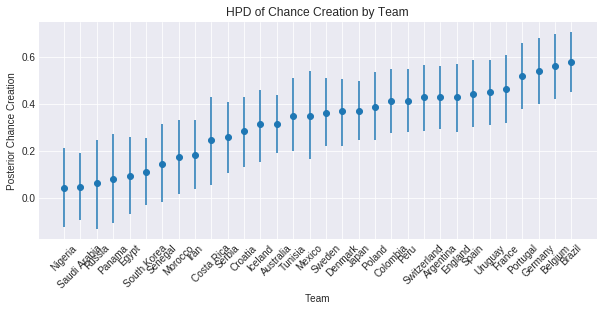

In [81]:
df_hpd = pd.DataFrame(pm.stats.hpd(trace['chance_creation'][:,wc_teams.i.values]), columns=['hpd_low', 'hpd_high'], index=wc_teams.team.values)
df_median = pd.DataFrame(pm.stats.quantiles(trace['chance_creation'][:,wc_teams.i.values])[50], columns=['hpd_median'], index=wc_teams.team.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.x, df_hpd.hpd_median, 
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T, 
             fmt='o')
axs.set_title('HPD of Chance Creation by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Chance Creation')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=45)

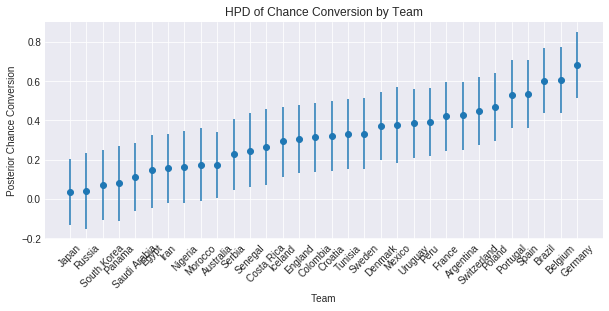

In [82]:
df_hpd = pd.DataFrame(pm.stats.hpd(trace['chance_quality'][:,wc_teams.i.values]), columns=['hpd_low', 'hpd_high'], index=wc_teams.team.values)
df_median = pd.DataFrame(pm.stats.quantiles(trace['chance_quality'][:,wc_teams.i.values])[50], columns=['hpd_median'], index=wc_teams.team.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.x, df_hpd.hpd_median, 
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T, 
             fmt='o')
axs.set_title('HPD of Chance Conversion by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Chance Conversion')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=45)

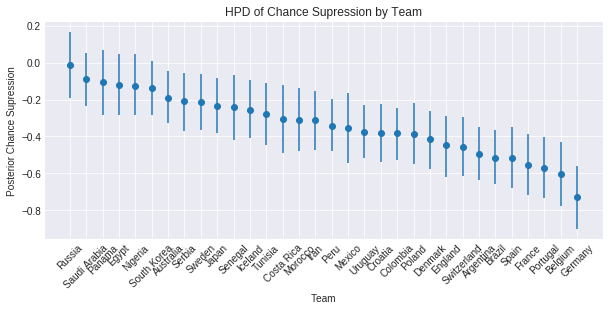

In [83]:
df_hpd = pd.DataFrame(pm.stats.hpd(trace['chance_supression'][:,wc_teams.i.values]), columns=['hpd_low', 'hpd_high'], index=wc_teams.team.values)
df_median = pd.DataFrame(pm.stats.quantiles(trace['chance_supression'][:,wc_teams.i.values])[50], columns=['hpd_median'], index=wc_teams.team.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median', ascending=False)
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.x, df_hpd.hpd_median, 
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T, 
             fmt='o')
axs.set_title('HPD of Chance Supression by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Chance Supression')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=45)

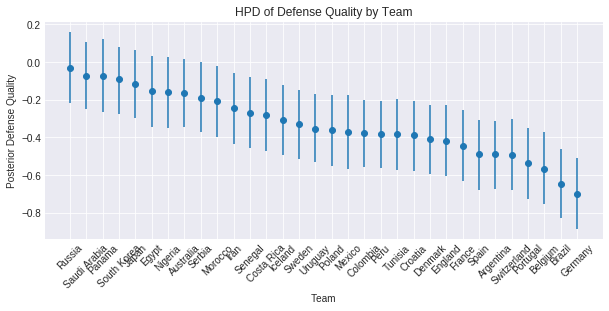

In [84]:
df_hpd = pd.DataFrame(pm.stats.hpd(trace['defense_quality'][:,wc_teams.i.values]), columns=['hpd_low', 'hpd_high'], index=wc_teams.team.values)
df_median = pd.DataFrame(pm.stats.quantiles(trace['defense_quality'][:,wc_teams.i.values])[50], columns=['hpd_median'], index=wc_teams.team.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median', ascending=False)
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.x, df_hpd.hpd_median, 
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T, 
             fmt='o')
axs.set_title('HPD of Defense Quality by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Defense Quality')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=45)

In [56]:
def simulate_match(trace, teams, home=(False,False)):
    num_samples = trace['chance_creation'].shape[0]
    idx = np.random.randint(0,num_samples)
    atts = trace['chance_creation'][idx, teams]
    defs = trace['chance_supression'][idx, teams]
    chance_quality = trace['chance_quality'][idx, teams]
    defense_quality = trace['defense_quality'][idx, teams]
    shots_inter = trace['shots_intercept'][idx]
    goals_inter = trace['goals_intercept'][idx]
    home_inter = trace['home'][idx]

    home_shots_theta = shots_inter + atts[0] + atts[1]
    if home[0]:
        home_shots_theta += home_inter
    away_shots_theta = shots_inter + atts[1] + atts[0]
    if home[1]:
        away_shots_theta += home_inter
    home_goals_theta = np.exp(goals_inter + home_shots_theta + chance_quality[0] + defense_quality[1])
    away_goals_theta = np.exp(goals_inter + away_shots_theta + chance_quality[1] + defense_quality[0])
    home_goals = np.random.poisson(home_goals_theta)
    away_goals = np.random.poisson(away_goals_theta)
    
    if home_goals > away_goals:
        return 'home'
    elif away_goals > home_goals:
        return 'away'
    else:
        return 'draw'
        
def simulate_group(group, trace, n_sims=100):
    indices = group.i.values
    sim_pts = []
    for _ in range(n_sims):
        pts = np.zeros(len(indices))
        for i in range(len(indices)):
            for j in range(i+1,len(indices)):
                home_i = indices[i]
                away_i = indices[j]
                if (group[group.i == home_i].team == 'Russia').values[0]:
                    home = (True,False)
                elif (group[group.i == away_i].team == 'Russia').values[0]:
                    home = (False,True)
                else:
                    home = (False,False)
                res = simulate_match(trace, [home_i,away_i], home)
                if res == 'home':
                    pts[i] += 3
                elif res == 'away':
                    pts[j] += 3
                else:
                    pts[i] += 1
                    pts[j] += 1
        sim_pts.append(pts)
    sim_pts = np.stack(sim_pts)
    df_hpd = pd.DataFrame(pm.stats.hpd(sim_pts), columns=['hpd_low', 'hpd_high'], index=group.i.values)
    df_median = pd.DataFrame(pm.stats.quantiles(sim_pts)[50], columns=['hpd_median'], index=group.i.values)
    df_hpd = df_hpd.join(df_median)
    df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
    df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
    group = group.join(df_hpd)
    group = group.sort_values(by='hpd_median', ascending=False)
    group = group.reset_index()
    group['x'] = group.index + .5
    return group

In [60]:
with mp.Pool(4) as pool:
    groups_res = pool.map(partial(simulate_group, trace=trace, n_sims=100), groups)

In [61]:
with open('group_sims.pkl', 'wb') as f:
    pickle.dump(groups_res, f)

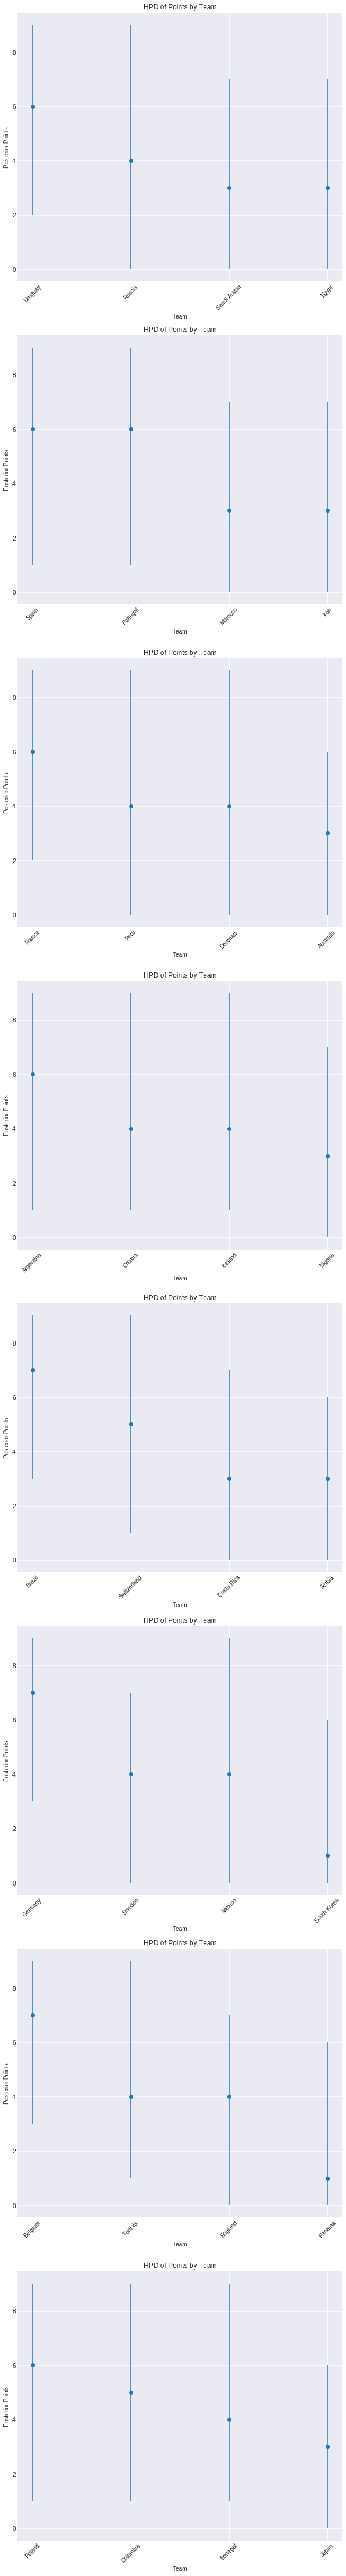

In [85]:
fig, axs = plt.subplots(nrows=len(groups_res), figsize=(10,80))
for ax, group in zip(axs, groups_res):
    ax.errorbar(group.x, group.hpd_median, 
                 yerr=(group[['relative_lower', 'relative_upper']].values).T, 
                 fmt='o')
    ax.set_title('HPD of Points by Team')
    ax.set_xlabel('Team')
    ax.set_ylabel('Posterior Points')
    _= ax.set_xticks(group.index + .5)
    _= ax.set_xticklabels(group['team'].values, rotation=45)